Import files

In [1]:
import os
import numpy as np
import pandas as pd
import torch

def read_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            mass, intensity = line.strip().split('\t')
            data.append([float(mass), float(intensity)])
    return np.array(data)

directory = r'C:\Users\Marshall\TEST DATA\TEST DATA\DalbergiaLatifolia'
file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_data = []
for file_path in file_paths:
    data = pd.read_csv(file_path,sep= '\t',header = 1)
    all_data.append(data)




Scale the data

In [2]:
all_data_scaled = []
for seq in all_data:
    seq = np.array(seq)
    mass_values = seq[:, 0]
    intensity_values = seq[:, 1]

    # Calculate the minimum and maximum intensity values for this sequence
    intensity_min = np.min(intensity_values)
    intensity_max = np.max(intensity_values)

    # Scale the intensity values using the max-min scaler
    scaled_intensity = (intensity_values - intensity_min) / (intensity_max - intensity_min)

    # Combine the scaled intensity values with the mass values
    scaled_seq = np.column_stack((mass_values, scaled_intensity))

    all_data_scaled.append(scaled_seq)

In [3]:
from torch.nn.utils.rnn import pad_sequence

#all_data_scaled = np.concatenate(all_data_scaled, axis=0)

max_seq_len = max(len(seq) for seq in all_data)

# Create a list of tensors for each sequence in the dataset
tensor_data = [torch.tensor(seq, dtype=torch.float32) for seq in all_data_scaled]

# Pad the sequences
padded_data = pad_sequence(tensor_data, batch_first=True, padding_value=0.0)


In [4]:
features = padded_data[:, :, 0].unsqueeze(-1)  # Mass values
targets = padded_data[:, :, 1].unsqueeze(-1)   # Intensity values

In [5]:
# Create a mask tensor for the features
features_mask = torch.ones_like(features, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    features_mask[i, len(seq):, 0] = False

# Create a mask tensor for the targets
targets_mask = torch.ones_like(targets, dtype=torch.bool)
for i, seq in enumerate(tensor_data):
    targets_mask[i, len(seq):, 0] = False


VAE setup

In [6]:
import torch
import torch.nn as nn

class RecurrentVAE(nn.Module):
    def __init__(self, feature_dim, target_dim, latent_dim, hidden_dim, num_layers, dropout_rate):
        super(RecurrentVAE, self).__init__()
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Encoder
        self.encoder_rnn = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.encoder_residual = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # Residual connection
        self.attention_linear = nn.Linear(hidden_dim * 2, 1)
        self.attention_pool = nn.AdaptiveAvgPool1d(1)
        self.mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.log_var = nn.Linear(hidden_dim * 2, latent_dim)

        # Variational Dropout
        self.variational_dropout = nn.Dropout(p=dropout_rate)

        # Decoder
        self.decoder_rnn = nn.LSTM(latent_dim + hidden_dim * 2, hidden_dim, num_layers, batch_first=True)
        self.decoder_residual = nn.Linear(hidden_dim, hidden_dim)  # Residual connection
        self.decoder_out = nn.Linear(hidden_dim, target_dim)

    def encode(self, features, mask=None):
        # print("Features shape:", features.shape)
        encoder_outputs, (h_n, _) = self.encoder_rnn(features)
        # print("Encoder outputs shape:", encoder_outputs.shape)
        # print("h_n shape:", h_n.shape)
    
        if mask is not None:
            # print("Mask shape:", mask.shape)
            encoder_outputs = encoder_outputs * mask
            # print("Masked encoder outputs shape:", encoder_outputs.shape)

        # Apply variational dropout to encoder outputs
        encoder_outputs = self.variational_dropout(encoder_outputs)

        # Apply residual connection
        encoder_outputs = encoder_outputs + self.encoder_residual(encoder_outputs)

        # Compute intensity-based attention weights from targets
        attention_weights = self.attention_linear(encoder_outputs)
        # print("Attention weights shape:", attention_weights.shape)  
        attention_weights = torch.softmax(attention_weights, dim=1)
        # print("Attention weights shape:", attention_weights.shape)
        
        # Compute attention-weighted representations
        attention_weighted_outputs = attention_weights * encoder_outputs
        # print("Attention-weighted outputs shape:", attention_weighted_outputs.shape)

        h_n = self.attention_pool(attention_weighted_outputs.transpose(1, 2)).squeeze(-1)
        #h_n = h_n.view(self.num_layers, -1, self.hidden_dim)[-1]
        # print("Reshaped h_n shape:", h_n.shape)
    
        mu = self.mu(h_n)
        log_var = self.log_var(h_n)
        return mu, log_var, attention_weighted_outputs

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, attention_weighted_outputs, seq_len):
        # Concatenate latent vector and attention-weighted representations
        decoder_input = torch.cat((z.unsqueeze(1).repeat(1, seq_len, 1), attention_weighted_outputs), dim=-1)
        
        outputs, _ = self.decoder_rnn(decoder_input)

        # Apply variational dropout to decoder outputs
        outputs = self.variational_dropout(outputs)

        # Apply residual connection
        outputs = outputs + self.decoder_residual(outputs)
        
        recon_targets = self.decoder_out(outputs)
        return recon_targets

    def forward(self, features, targets, mask=None):
        # print("Features shape:", features.shape)
        # print("Targets shape:", targets.shape)
        if mask is not None:
            features_mask, targets_mask = mask
        else:
            features_mask, targets_mask = None, None
        mu, log_var, attention_weighted_outputs = self.encode(features, mask=features_mask)
        # print("Mu shape:", mu.shape)
        # print("Log-variance shape:", log_var.shape)
        z = self.reparameterize(mu, log_var)
        # print("Reparameterized z shape:", z.shape)
        seq_len = targets.size(1)
        targets_recon = self.decode(z, attention_weighted_outputs,seq_len)
        # print("Reconstructed targets shape:", targets_recon.shape)

        if targets_mask is not None:
            targets_recon = targets_recon * targets_mask

        return targets_recon, mu, log_var

Training the VAE

In [7]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.01)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)



def train_and_evaluate(train_features, train_targets, val_features, val_targets, 
                       train_features_mask, train_targets_mask, val_features_mask, val_targets_mask):
    # Instantiate the model
    vae = RecurrentVAE(feature_dim=1, target_dim=1, latent_dim=64, hidden_dim=128, num_layers=3, dropout_rate=0.2)
    
    vae.apply(init_weights)
    # Move the model to GPU (if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = vae.to(device)
    
    # Move the data to GPU (if available)
    train_features = train_features.to(device)
    train_targets = train_targets.to(device)
    train_features_mask = train_features_mask.to(device)
    train_targets_mask = train_targets_mask.to(device)
    
    val_features = val_features.to(device)
    val_targets = val_targets.to(device)
    val_features_mask = val_features_mask.to(device)
    val_targets_mask = val_targets_mask.to(device)
    
    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
    reconstruction_loss = F.mse_loss
    
    # Training loop
    num_epochs = 10000
    batch_size = 7
    clip_threshold = 5.0
    
    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_div = 0
        num_batches = 0
        
        for i in range(0, len(train_features), batch_size):
            batch_features = train_features[i:i+batch_size]
            batch_targets = train_targets[i:i+batch_size]
            batch_features_mask = train_features_mask[i:i+batch_size]
            batch_targets_mask = train_targets_mask[i:i+batch_size]
            
            optimizer.zero_grad()
            
            targets_recon, mu, log_var = vae(batch_features, batch_targets,
                                             mask=(batch_features_mask, batch_targets_mask))
            
            recon_loss = reconstruction_loss(targets_recon * batch_targets_mask,
                                             batch_targets * batch_targets_mask,
                                             reduction='sum')
            
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            loss = recon_loss + kl_div
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_threshold)
            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_div.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        avg_kl_div = total_kl_div / num_batches
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {avg_recon_loss:.4f}, KL Div: {avg_kl_div:.4f}")
    
    # Evaluate on validation set
    vae.eval()
    with torch.no_grad():
        val_targets_recon, _, _ = vae(val_features, val_targets, mask=(val_features_mask, val_targets_mask))
        val_loss = reconstruction_loss(val_targets_recon * val_targets_mask,
                                       val_targets * val_targets_mask,
                                       reduction='mean')
    
    return vae, val_loss.item()

# K-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_losses = []
trained_models = []

best_model = None
best_loss = float('inf')

for fold, (train_index, val_index) in enumerate(kf.split(features)):
    print(f"Fold {fold + 1}/{k}")
    
    train_features, val_features = features[train_index], features[val_index]
    train_targets, val_targets = targets[train_index], targets[val_index]
    train_features_mask, val_features_mask = features_mask[train_index], features_mask[val_index]
    train_targets_mask, val_targets_mask = targets_mask[train_index], targets_mask[val_index]
    
    trained_model, val_loss = train_and_evaluate(train_features, train_targets, val_features, val_targets,
                                  train_features_mask, train_targets_mask, val_features_mask, val_targets_mask)
    
    fold_losses.append(val_loss)
    trained_models.append(trained_model)
    print(f"Validation Loss for Fold {fold + 1}: {val_loss:.4f}")

    # Check if this model is the best so far
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = trained_model
        best_fold = fold

average_loss = np.mean(fold_losses)
print(f"Average Validation Loss across {k} folds: {average_loss:.4f}")

# Save the best model
if best_model is not None:
    checkpoint = {
        'model_state_dict': best_model.state_dict(),
        'best_fold': best_fold,
        'best_loss': best_loss,
        'all_fold_losses': fold_losses,
        'average_loss': average_loss,
        'model_hyperparameters': {
            'feature_dim': 1,
            'target_dim': 1,
            'latent_dim': 64,
            'hidden_dim': 128,
            'num_layers': 3,
            'dropout_rate': 0.2
        },
        'training_hyperparameters': {
            'num_epochs': 10000,
            'batch_size': 7,
            'learning_rate': 0.001,
            'clip_threshold': 5.0
        },
        'data_info': {
            'num_samples': len(features),
            'num_folds': k
        }
    }
    
    torch.save(checkpoint, 'best_model_checkpoint.pth')
    print(f"Best model saved with validation loss: {best_loss:.4f}")
# To load the checkpoint later:
# checkpoint = torch.load('best_model_checkpoint.pth')
# best_model = RecurrentVAE(**checkpoint['model_hyperparameters'])
# best_model.load_state_dict(checkpoint['model_state_dict'])
# best_model.eval()
# 
# best_loss = checkpoint['best_loss']
# best_fold = checkpoint['best_fold']
# average_loss = checkpoint['average_loss']
# ... (access other saved variables as needed)

Fold 1/5
Epoch [100/10000], Recon Loss: 18.0366, KL Div: 0.0005
Epoch [200/10000], Recon Loss: 17.8998, KL Div: 0.0005
Epoch [300/10000], Recon Loss: 17.2080, KL Div: 0.0001
Epoch [400/10000], Recon Loss: 14.4148, KL Div: 0.0001
Epoch [500/10000], Recon Loss: 11.4723, KL Div: 0.0003
Epoch [600/10000], Recon Loss: 9.2378, KL Div: 0.0005
Epoch [700/10000], Recon Loss: 7.8475, KL Div: 0.0004
Epoch [800/10000], Recon Loss: 6.6868, KL Div: 0.0006
Epoch [900/10000], Recon Loss: 5.9982, KL Div: 0.0008
Epoch [1000/10000], Recon Loss: 5.3581, KL Div: 0.0004
Epoch [1100/10000], Recon Loss: 4.2716, KL Div: 0.0003
Epoch [1200/10000], Recon Loss: 4.1293, KL Div: 0.0004
Epoch [1300/10000], Recon Loss: 3.6071, KL Div: 0.0001
Epoch [1400/10000], Recon Loss: 3.3772, KL Div: 0.0001
Epoch [1500/10000], Recon Loss: 3.3794, KL Div: 0.0002
Epoch [1600/10000], Recon Loss: 3.5307, KL Div: 0.0001
Epoch [1700/10000], Recon Loss: 3.2216, KL Div: 0.0001
Epoch [1800/10000], Recon Loss: 3.2024, KL Div: 0.0000
Epoch

Create output

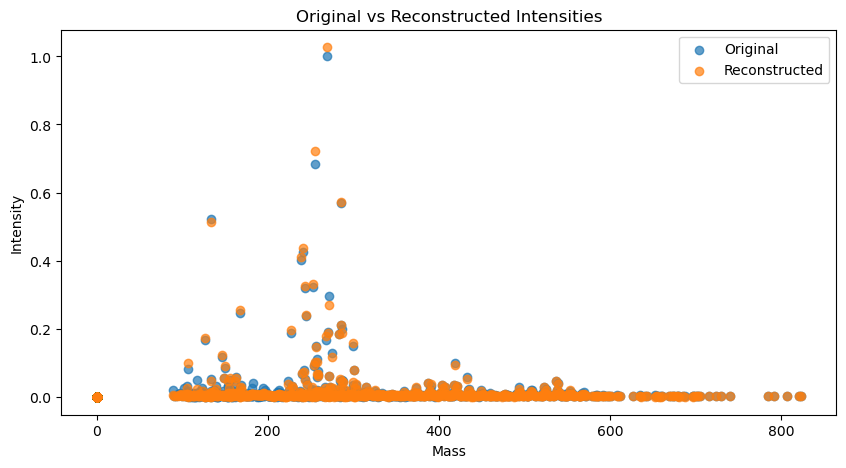

In [34]:
import matplotlib.pyplot as plt

# Remove the mask from the features, targets, and reconstructed targets
original_features = batch_features.detach().cpu().numpy().squeeze()
original_targets = batch_targets.detach().cpu().numpy().squeeze()
reconstructed_targets = targets_recon.detach().cpu().numpy().squeeze()
reconstructed_features = batch_features.detach().cpu().numpy().squeeze()
# Plot the original and reconstructed targets against the original features
plt.figure(figsize=(10, 5))
plt.scatter(original_features, original_targets, label='Original', alpha=0.7)
plt.scatter(reconstructed_features, reconstructed_targets, label='Reconstructed', alpha=0.7)
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.title('Original vs Reconstructed Intensities')
plt.show()

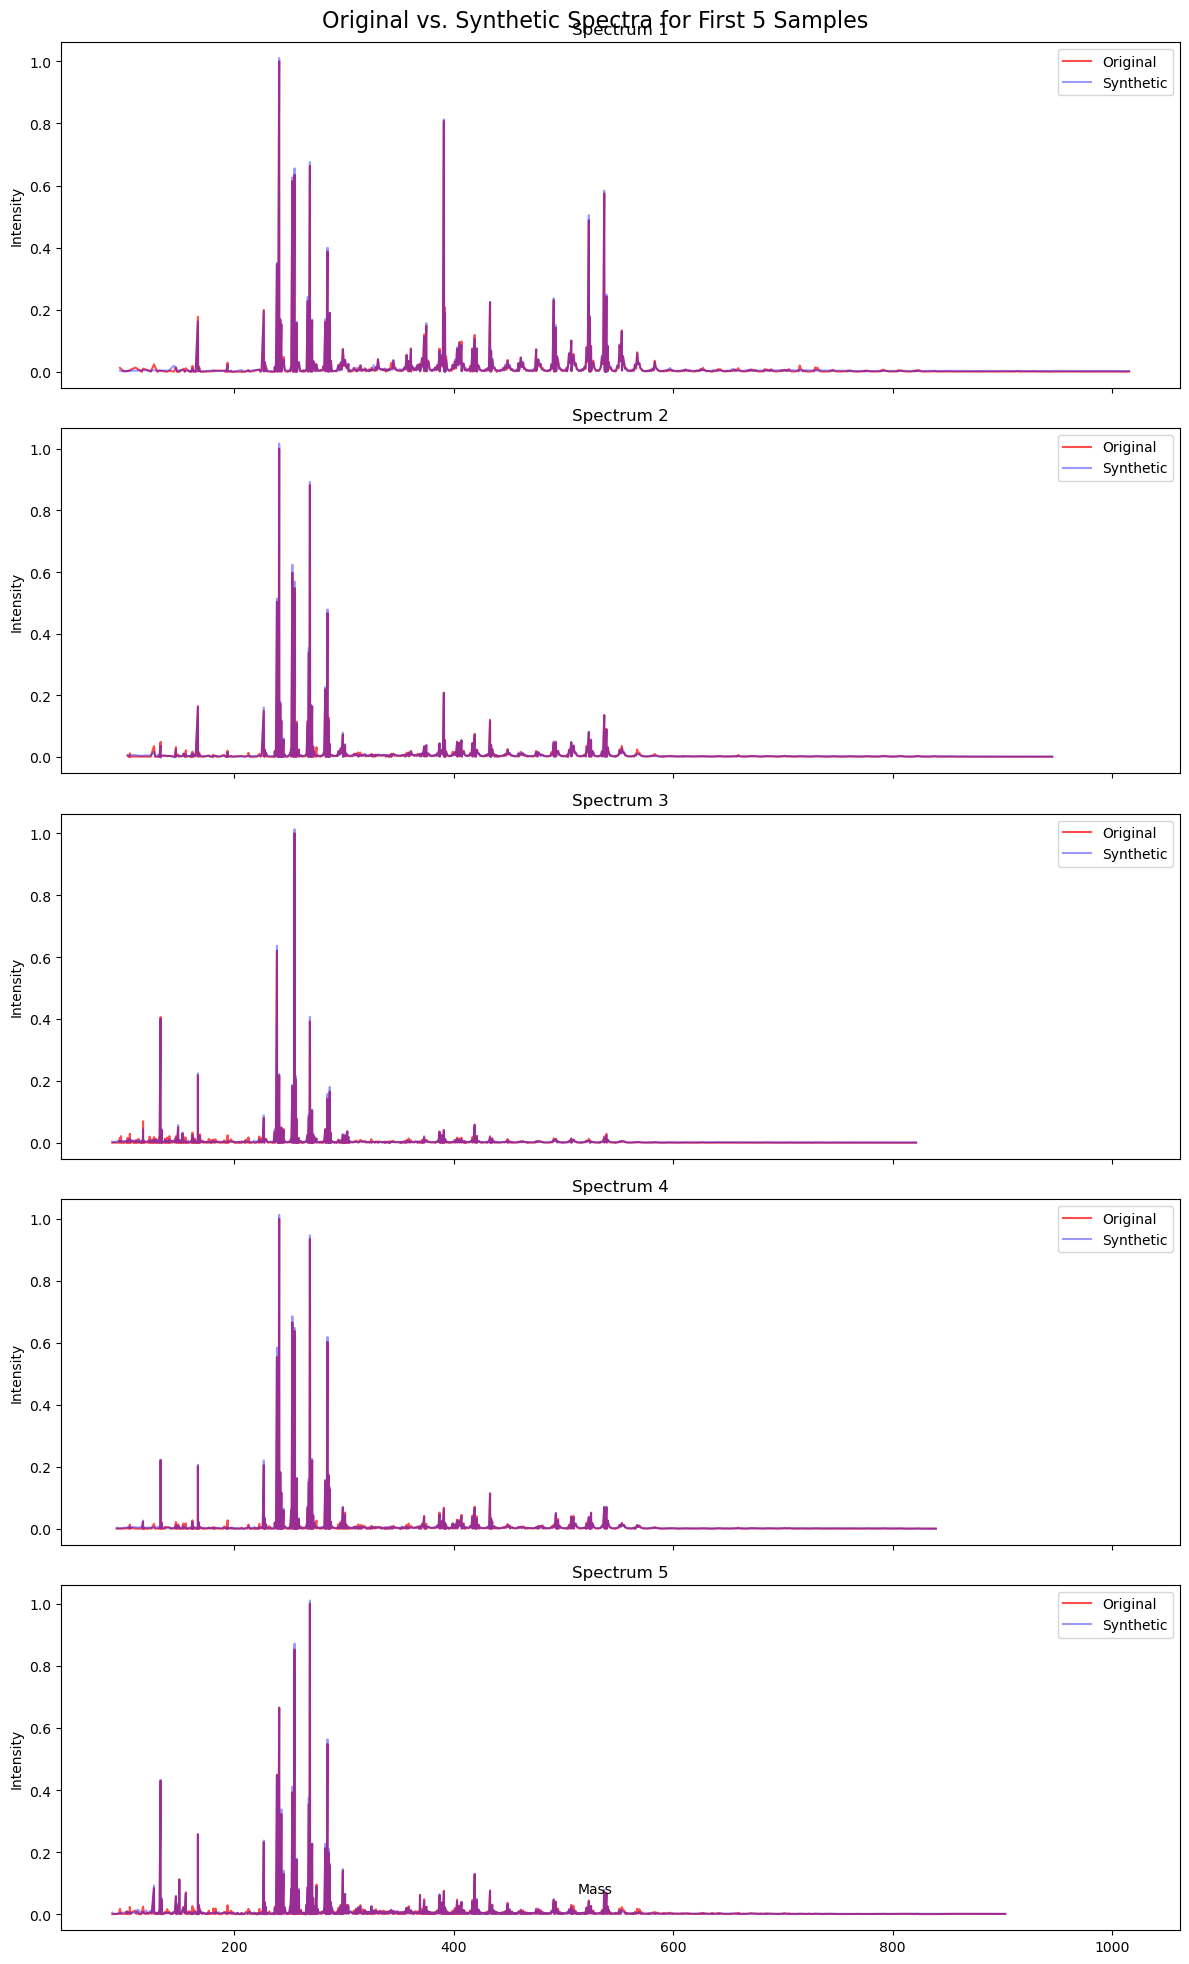

In [61]:
import torch
import matplotlib.pyplot as plt

# Set the model to evaluation mode
vae.eval()

# Select a spectra from your dataset
index = 10  # Choose the index of the spectra you want to plot
original_features = features[index]
original_targets = targets[index]

latent_dim = 64
num_spectra = 5

fig, axes = plt.subplots(num_spectra, 1, figsize=(12, 4*num_spectra), sharex=True)
fig.suptitle('Original vs. Synthetic Spectra for First 5 Samples', fontsize=16)

for i in range(num_spectra):
    # Select a spectrum from your dataset
    original_features = features[i]
    original_targets = targets[i]

    # Generate a synthetic spectrum using your model
    with torch.no_grad():
        latent_sample = torch.randn(1, latent_dim)  # Generate a random latent sample
        synthetic_targets, _, _ = vae(original_features.unsqueeze(0), original_targets.unsqueeze(0)) # Generate synthetic targets

    # # Print shapes for debugging
    # print(f"Spectrum {i+1}:")
    # print(f"Original features shape: {original_features.shape}")
    # print(f"Original targets shape: {original_targets.shape}")
    # print(f"Synthetic targets shape: {synthetic_targets.shape}")
    # print(f"Features mask shape: {features_mask[i].shape}")
    # print(f"Targets mask shape: {targets_mask[i].shape}")

    # Remove padding from the original and synthetic spectra
    original_features = original_features[features_mask[i]]
    original_targets = original_targets[targets_mask[i]]
    
    # Adjust this line based on the shape of synthetic_targets
    synthetic_targets = synthetic_targets.squeeze()
    if synthetic_targets.dim() > 1:
        synthetic_targets = synthetic_targets[0]  # Take the first row if it's 2D
    synthetic_targets = synthetic_targets[:len(original_targets)]

    # Convert to numpy for plotting
    original_features_np = original_features.cpu().numpy()
    original_targets_np = original_targets.cpu().numpy()
    synthetic_targets_np = synthetic_targets.cpu().numpy()

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(original_features_np, original_targets_np, label='Original', color='red', alpha=0.7)
    ax.plot(original_features_np, synthetic_targets_np, label='Synthetic', color='blue', alpha=0.4)
    
    ax.set_ylabel('Intensity')
    ax.legend()
    ax.set_title(f'Spectrum {i+1}')

# Set common x-label
fig.text(0.5, 0.04, 'Mass', ha='center', va='center')

plt.tight_layout()
plt.show()

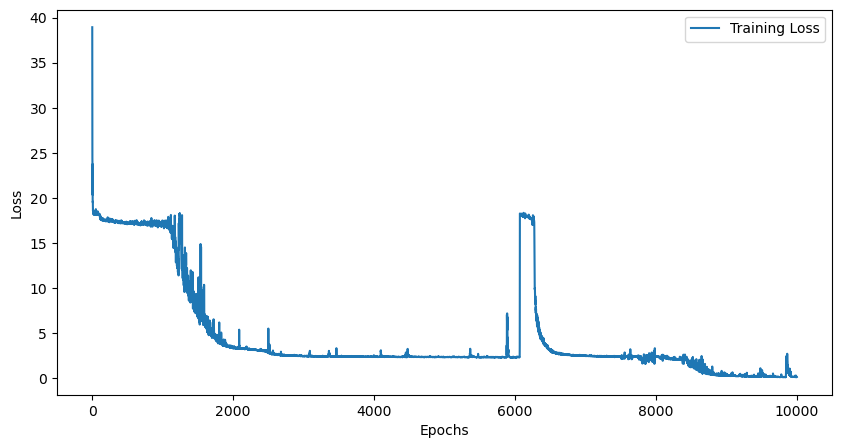

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Save the model
torch.save(vae.state_dict(), 'vae_model.pth')

Shape of latent_vectors: (22, 64)
Number of sequences: 22
First few sequence lengths: [[825], [970], [1193], [1127], [1408]]
Min sequence length: 507
Max sequence length: 1408


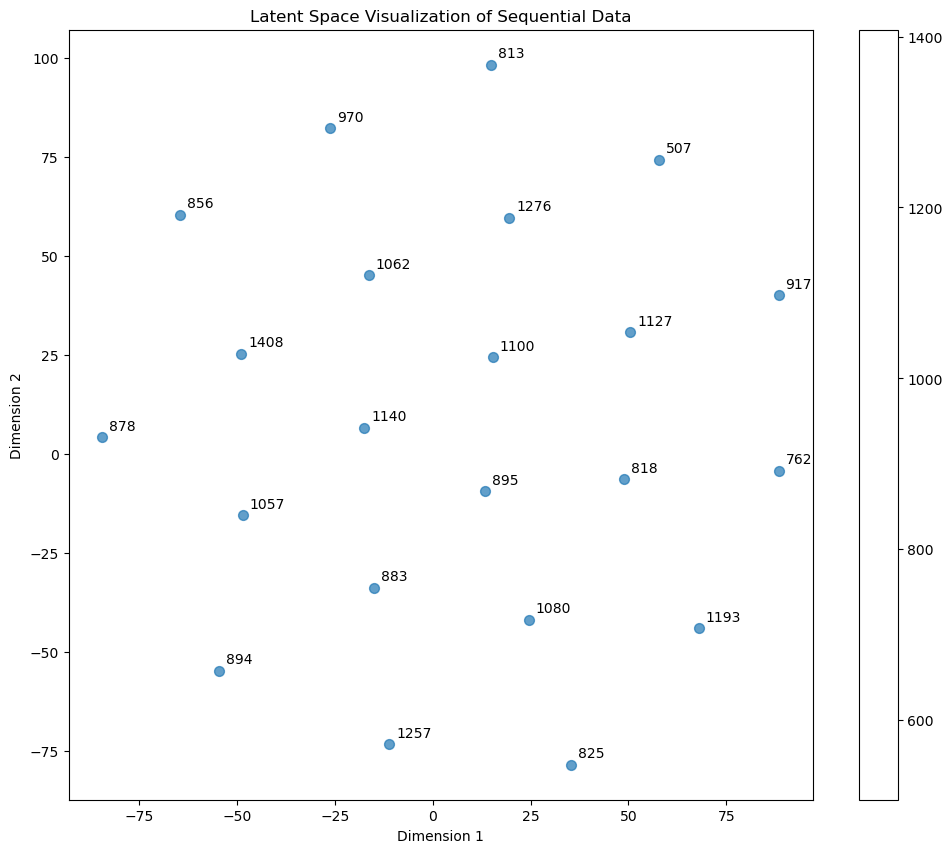

Number of samples: 22
Dimensionality of latent space: 64
Number of sequences: 22
Total length of all sequences: 21718


In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def encode_data(vae, features, features_mask, device, batch_size=7):
    vae.eval()
    latent_vectors = []
    attention_outputs = []
    sequence_lengths = []
    
    with torch.no_grad():
        for i in range(0, len(features), batch_size):
            batch_features = features[i:i+batch_size].to(device)
            batch_features_mask = features_mask[i:i+batch_size].to(device)
            
            # Encode the data
            mu, log_var, attention_weighted_outputs = vae.encode(batch_features, mask=batch_features_mask)
            
            latent_vectors.append(mu.cpu().numpy())
            attention_outputs.append(attention_weighted_outputs.cpu().numpy())
            
            # Assuming the second dimension is the sequence length
            sequence_lengths.extend(batch_features_mask.sum(dim=1).cpu().numpy().tolist())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    attention_outputs = np.concatenate(attention_outputs, axis=0)
    return latent_vectors, attention_outputs, sequence_lengths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = trained_models[0].to(device)  # Make sure your model is on the correct device
# Encode your data
latent_vectors, attention_outputs, sequence_lengths = encode_data(vae, features, features_mask, device)

# Flatten sequence_lengths if it's a list of lists
flat_sequence_lengths = [item for sublist in sequence_lengths for item in sublist]

# Print diagnostic information
print(f"Shape of latent_vectors: {latent_vectors.shape}")
print(f"Number of sequences: {len(sequence_lengths)}")
print(f"First few sequence lengths: {sequence_lengths[:5]}")
print(f"Min sequence length: {min(flat_sequence_lengths)}")
print(f"Max sequence length: {max(flat_sequence_lengths)}")

# If latent space is higher dimensional, use t-SNE
if latent_vectors.shape[1] > 2:
    n_samples = latent_vectors.shape[0]
    perplexity = min(30, n_samples - 1)
    try:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        latent_vectors_2d = tsne.fit_transform(latent_vectors)
    except ValueError as e:
        print(f"Error with t-SNE: {e}")
        print("Falling back to PCA for dimensionality reduction")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        latent_vectors_2d = pca.fit_transform(latent_vectors)
else:
    latent_vectors_2d = latent_vectors

plt.figure(figsize=(12, 10))

# Plot all points
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], alpha=0.7, s=50)

# Annotate points with sequence lengths
for i, (x, y) in enumerate(latent_vectors_2d):
    plt.annotate(str(sum(sequence_lengths[i])), (x, y), xytext=(5, 5), textcoords='offset points')

plt.title("Latent Space Visualization of Sequential Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], 
                         c=[sum(seq) for seq in sequence_lengths], cmap='viridis', alpha=0))
plt.show()

# Print some information about the latent vectors
print(f"Number of samples: {latent_vectors.shape[0]}")
print(f"Dimensionality of latent space: {latent_vectors.shape[1]}")
print(f"Number of sequences: {len(sequence_lengths)}")
print(f"Total length of all sequences: {sum(flat_sequence_lengths)}")


# Optionally, create an animation to show the progression
from matplotlib.animation import FuncAnimation

def animate_sequence(sequence, interval=200):
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter([], [], s=50)
    line, = ax.plot([], [], 'r-', alpha=0.5)
    ax.set_xlim(sequence[:, 0].min(), sequence[:, 0].max())
    ax.set_ylim(sequence[:, 1].min(), sequence[:, 1].max())
    
    def update(frame):
        scatter.set_offsets(sequence[:frame+1])
        line.set_data(sequence[:frame+1, 0], sequence[:frame+1, 1])
        return scatter, line

    anim = FuncAnimation(fig, update, frames=len(sequence), interval=interval, blit=True)
    plt.close(fig)
    return anim

# # Choose a sequence to animate (e.g., the first sequence)
# sequence_to_animate = latent_vectors_2d[:sequence_lengths[0]]
# anim = animate_sequence(sequence_to_animate)
# anim.save('latent_space_sequence.gif', writer='pillow')